In [2]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
import numpy as np
import random

/home/xingyan/anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

class Net(torch.nn.Module):
    def __init__(self, dims, device=None):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1], device=device).cuda()]

    def predict(self, x):
        goodness_per_label = []
        for label in range(16):
            h = x
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print(f"training layer {i}")
            h_pos, h_neg = layer.train(h_pos, h_neg)

class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 100000
        self.device = device

    def forward(self, x):
        if len(x.shape) == 1:
            x_direction = torch.nn.functional.normalize(x, dim=0)
            x_direction = x_direction.unsqueeze(0)
        else:
            x_direction = torch.nn.functional.normalize(x)
        x_direction = torch.tensor(x_direction, dtype=torch.float32).to(self.device)
        return self.relu(
            torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for _ in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

def Channel(x): 
    # add some noise
    stddev = np.sqrt(1 / (10 ** (6)))
    noise = torch.normal(mean=0, std=stddev, size=x.shape).to(device)
    return x + noise

def dec_to_bin(input, out_length=4):
    tmp = str(bin(input))[2:]
    if len(tmp) > out_length:
        raise("input length too short")
    if len(tmp) < out_length:
        tmp = (out_length - len(tmp)) * "0" + tmp
    output = list()
    for i in range(out_length):
        output.append(int(tmp[i]))
    return np.array(output)

def generate_data(length):
    """
    generate training data, returns true label, false label, data
    """
    data_true = list()
    data_false = list()
    data_value = list()
    for _ in range(length):
        value = random.randrange(0, 16)
        label_true = value
        label_false = random.randrange(0, 16)
        while label_false == value:
            label_false = random.randrange(0, 16)

        value = dec_to_bin(value)
        label_true = dec_to_bin(label_true)
        label_false = dec_to_bin(label_false)

        data_true.append(label_true)
        data_false.append(label_false)
        data_value.append(value)
    return np.array(data_true), np.array(data_false), np.array(data_value)

def generate_spec_data(label, data):
    bi_label = dec_to_bin(label)
    bi_data = dec_to_bin(data)

    return np.array(bi_label), np.array(bi_data)



In [4]:
label_true, label_false, data = generate_data(50000)

K = 16
N = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
net_in = Net([8, 32, 14], device)
net_out = Net([14 + 4, 32, 16], device)

# training here
x_pos = np.concatenate((label_true, data), axis=1)
x_neg = np.concatenate((label_false, data), axis=1)

label_true = torch.Tensor(label_true).to(device)
label_false = torch.Tensor(label_false).to(device)

x_pos = torch.Tensor(x_pos).to(device)
x_neg = torch.Tensor(x_neg).to(device)
    
net_in.train(x_pos, x_neg)

imm_pos = Channel(net_in.forward(x_pos))
imm_neg = Channel(net_in.forward(x_pos))

imm_pos = torch.cat((label_true, imm_pos), dim=1)
imm_neg = torch.cat((label_false, imm_neg), dim=1)

net_out.train(imm_pos, imm_neg)


training layer 0


100%|██████████| 100000/100000 [02:55<00:00, 570.60it/s]


training layer 1


100%|██████████| 100000/100000 [02:49<00:00, 590.05it/s]


training layer 0


100%|██████████| 100000/100000 [02:49<00:00, 588.43it/s]


training layer 1


100%|██████████| 100000/100000 [03:04<00:00, 542.64it/s]


In [26]:
# testing here
tot = 0
err = 0
t_three = 0
print("testing")
for _ in range(100):
    label_true, label_false, data = generate_data(1)
    input = np.concatenate((label_true, data), axis=1)
    input = torch.Tensor(np.array(input)).to(device)

    imm = Channel(net_in.forward(input))

    outputs = list()
    for i in range(16):
        tmp = torch.Tensor(np.array([dec_to_bin(i)])).to(device)

        cur_imm = torch.cat([tmp, imm], dim=1)

        output = net_out.forward(cur_imm)

        outputs.append(output)
        
    label_true = label_true.tolist()[0]
    for i in range(4):
        label_true[i] = str(label_true[i])
    ground_truth = "0b" + "".join(label_true)
    ground_truth = int(ground_truth, 2)

    guesses = list()
    for v in range(len(outputs)):
        guesses.append([v, torch.sum(outputs[v]).item()])
    guesses.sort(key=lambda x: x[1], reverse=True)
    guess = guesses[0][0]

    # print(ground_truth)
    # print(guesses)

    for i in range(3):
        if int(ground_truth) == guesses[i][0]:
            t_three += 1

    if int(ground_truth) == int(guess):
        tot += 1
    else:
        err += 1
        tot += 1

print(f"test error: {err/tot}")
print(f"top three rate: {t_three/tot}")


testing


/home/xingyan/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test error: 0.02
top three rate: 1.0


In [39]:
# generating 128 bit data, seperate into 32 4 bit sections, and encode each section seperately
corr = 0
tot = 0
num_errors = []
for i in tqdm(range(100)):
    # generate data with length n, seperate into m k length sections
    n = 128
    k = 4
    if n % k != 0:
        raise("Cannot seperate data")

    data = np.random.binomial(1, 0.5, n)
    sep_data = np.split(data, n/k)

    decoded = list()
    for section in sep_data:
        input = torch.Tensor(section).to(device)
        input = torch.cat([input, input])
        imm = Channel(net_in.forward(input))

        outputs = list()
        for i in range(16):
            tmp = torch.Tensor(np.array([dec_to_bin(i)])).to(device)
            cur_imm = torch.cat([tmp, imm], dim=1)
            output = net_out.forward(cur_imm)
            outputs.append(output)
        
        guesses = list()
        for v in range(len(outputs)):
            guesses.append([dec_to_bin(v), torch.sum(outputs[v]).item()])
        guesses.sort(key=lambda x: x[1], reverse=True)
        guess = guesses[0][0]

        decoded.append(guess)

    decoded = np.concatenate(decoded)

    num_errors.append(np.sum(np.absolute(data-decoded)))

    if (data==decoded).all():
        corr += 1
        tot += 1
    else:
        tot += 1

print(f"Correct decoding rate: {corr/tot}")
print(f"errors for the trials: {num_errors}")

100%|██████████| 100/100 [00:19<00:00,  5.15it/s]

Correct decoding rate: 0.44
errors for the trials: [1, 0, 1, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 1, 2, 0, 3, 0, 1, 1, 4, 1, 0, 1, 2, 0, 4, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 3, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 4, 2, 1, 5, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 3, 0, 2, 0, 2, 0, 0, 0, 1, 1, 5, 3, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]


In [28]:
# utils for seperating data by convolving 
data = np.random.binomial(1, 0.5, n)
def sep_data_conv(data, padding, stride, n=128, k=4):
    sep_data = list()
    sep_index = list()
    tmp_data = [0] * padding + list(data) + [0] * padding

    for i in range(0, len(tmp_data)-padding, stride):
        sep_data.append(tmp_data[i: i+k])
            
    for i in range(0, len(tmp_data)-padding, stride):
        sep_index.append([j for j in range(i, i+k)])

    return sep_data, sep_index

def restore_data_conv(sep_data, sep_index, padding, n=128, k=4):
    restored_data = [[] for _ in range(n + padding * 2)]
    for i in range(len(sep_data)):
        for j in range(len(sep_index[i])):
            restored_data[sep_index[i][j]].append(sep_data[i][j])

    output = list()
    for i in range(padding, n + padding):
        tmp = restored_data[i]
        ones = tmp.count(1)
        zeros = tmp.count(0)
        if ones >= zeros:
            output.append(1)
        else:
            output.append(0)

    return np.array(output)

sep_data, sep_index = sep_data_conv(data, 3, 3)
print(data)
print(sep_data)
print(sep_index)

restored_data = restore_data_conv(sep_data, sep_index, 3)
print(restored_data)

[0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0
 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0]
[[0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 1], [1, 1, 0, 1], [1, 1, 1, 0], [0, 0, 1, 0], [0, 1, 0, 1], [1, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 1], [1, 1, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 1], [1, 1, 0, 0], [0, 1, 0, 1], [1, 1, 0, 0], [0, 1, 0, 1], [1, 1, 1, 0], [0, 1, 1, 0], [0, 0, 0, 0]]
[[0, 1, 2, 3], [3, 4, 5, 6], [6, 7, 8, 9], [9, 10, 11, 12], [12, 13, 14, 15], [15, 16, 17, 18], [18, 19, 20, 21], [21, 22, 23, 24], [24, 25, 26, 27], [27, 28, 29, 30], [30, 31, 32, 33], [33, 34, 35, 36], [36, 37, 38, 39], [39, 40, 41, 42], [42, 43, 44, 45], [45, 46, 47, 48], [48, 49, 50, 51], [51, 52, 53, 54], [54, 55, 56, 57], [57, 58, 59, 60], [60, 61, 62, 63], [63, 64, 65, 66], [66, 67, 68, 69]]
[0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0
 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0]


In [40]:
# generate data with length n, use convolution to create n k length sections
n = 128
k = 4

corr = 0
tot = 0
num_errors = []
for i in tqdm(range(100)): 
    data = np.random.binomial(1, 0.5, n)
    padding = 3
    stride = 1
    sep_data, sep_index = sep_data_conv(data, padding, stride)

    decoded = list()
    for section in sep_data:
        input = torch.Tensor(section).to(device)
        input = torch.cat([input, input])
        imm = Channel(net_in.forward(input))

        outputs = list()
        for i in range(16):
            tmp = torch.Tensor(np.array([dec_to_bin(i)])).to(device)
            cur_imm = torch.cat([tmp, imm], dim=1)
            output = net_out.forward(cur_imm)
            outputs.append(output)
            
        guesses = list()
        for v in range(len(outputs)):
            guesses.append([dec_to_bin(v), torch.sum(outputs[v]).item()])
        guesses.sort(key=lambda x: x[1], reverse=True)
        guess = guesses[0][0]
        
        decoded.append(guess)

    output = restore_data_conv(decoded, sep_index, padding)

    num_errors.append(np.sum(np.absolute(data-output)))

    if (data==output).all():
        corr += 1
        tot += 1
    else:
        tot += 1

print(f"Correct decoding rate: {corr/tot}")
print(f"errors for the trials: {num_errors}")

100%|██████████| 100/100 [00:19<00:00,  5.19it/s]

Correct decoding rate: 0.32
errors for the trials: [0, 0, 3, 1, 0, 1, 0, 1, 0, 0, 1, 1, 2, 2, 8, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 4, 2, 1, 0, 2, 0, 0, 1, 2, 2, 3, 2, 1, 2, 1, 0, 0, 1, 1, 1, 1, 2, 0, 2, 0, 0, 2, 0, 1, 6, 5, 0, 0, 2, 1, 2, 2, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 0, 2, 0, 1, 2, 3, 0, 2, 0, 2, 0, 4, 2, 2, 0, 1, 0, 1, 2, 2, 0, 7, 2, 1]


In [34]:
import matplotlib.pyplot as plt

/home/xingyan/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


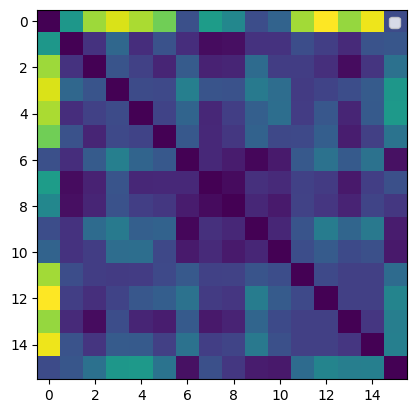

In [35]:
res = np.zeros((16,16))
codeword = np.zeros((16,14))
for i in range(16):
    # test_data = np.random.binomial(1, 0.5, [1, block_length])
    test_data = torch.Tensor(dec_to_bin(i)).unsqueeze(0)
    # print(test_data)
    label_true = test_data

    test_data = torch.Tensor(test_data).to(device)
    label_true = torch.Tensor(label_true).to(device)

    input = torch.cat([label_true, test_data], dim=1)

    imm_no_channel = net_in.forward(input)
    # imm_no_channel /= torch.sum(imm_no_channel**2)
    codeword[i,:] = imm_no_channel.cpu().detach().numpy()
for i in range(16):
    for j in range(16):
        res[i,j]= np.sum((codeword[i]-codeword[j])**2)

plt.legend()
plt.imshow(res)

In [36]:
for i in range(16):
    res[i,i]+=100
np.min(res,axis=0)

array([26.33681014,  3.7794583 ,  3.94444691, 20.27606389, 11.96544109,
        9.06688867,  1.94717957,  3.55755718,  3.55755718,  1.94717957,
        7.84073798, 20.27606389, 15.7241279 ,  3.94444691, 17.78518779,
        5.20273887])